### 소프트맥스 회귀(Softmax Regression)
- 소프트맥스 회귀는 선택지의 개수만큼의 차원을 가지는 벡터를 만들고, 해당 벡터가 벡터의 모든 원소의 합이 1이 되도록 원소들의 값을 변환시키는 어떤 함수를 지나게 만들어야 합니다
- 소프트맥스의 결과의 각 차원은, 각 클래스가 정답일 확률
- H(X)=softmax(WX+B)
- LogSoftmax + NLLLoss 또는
- Softmax + CrossEntropy

### torch.nn과 torch.nn.functional의 차이

In [ ]:
input = torch.randn(3, 5, requires_grad=True) 
target = torch.empty(3, dtype=torch.long).random_(5) 

- loss = torch.nn.CrossEntropyLoss()(output, target) --> class


In [78]:
loss_class = nn.CrossEntropyLoss() 
loss = loss_class(input, target) 
loss.backward()
loss

tensor(1.9639, grad_fn=<NllLossBackward>)

- loss = torch.nn.functional.nll_loss(output, target) --> function

In [88]:
loss = F.cross_entropy(input, target) 
loss.backward()
loss

tensor(1.7231, grad_fn=<NllLossBackward>)

### 소프트맥스 회귀의 loss function 구현하기 (low level)
- cross entropy

In [2]:
import torch
import torch.nn.functional as F

In [10]:
z = torch.FloatTensor([1, 2, 3]) # (1,3)
y_hat = F.softmax(z, dim=0) # 행방향에 대해서
y_hat

tensor([0.0900, 0.2447, 0.6652])

In [11]:
z = torch.FloatTensor([[1], [2], [3]]) # (3,1)
y_hat = F.softmax(z, dim=0) # 행방향에 대해서
y_hat

tensor([[0.0900],
        [0.2447],
        [0.6652]])

In [23]:
z = torch.rand(3, 5, requires_grad=True)
y_hat = F.softmax(z, dim=1) # 열방향에 대해서
y_hat

tensor([[0.1888, 0.1792, 0.2882, 0.1664, 0.1774],
        [0.1831, 0.2625, 0.1892, 0.2301, 0.1351],
        [0.1837, 0.1717, 0.1599, 0.2414, 0.2434]], grad_fn=<SoftmaxBackward>)

In [27]:
y = torch.randint(5, (3,)).long()
print(y) # (3,)
print(y.unsqueeze(1)) # (3,1)

tensor([3, 1, 4])
tensor([[3],
        [1],
        [4]])


In [32]:
y_one_hot = torch.zeros_like(y_hat)
# .scatter_(dim, tensor, 채울 값)
y_one_hot.scatter_(1, y.unsqueeze(1),1)
y_one_hot

tensor([[0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.]])

In [33]:
nll_loss = (y_one_hot * -torch.log(y_hat)).sum(dim=1).mean()
nll_loss

tensor(1.5147, grad_fn=<MeanBackward0>)

### 소프트맥스 회귀의 loss function 구현하기 (high level)


#### 1. F.softmax() + torch.log() = F.log_softmax()

In [49]:
z = torch.rand(3, 5, requires_grad=True) # softmax들어가기전
print(z,'\n') 
print(torch.log(F.softmax(z, dim=1)))
# 둘이 같음
print(F.log_softmax(z, dim=1))

tensor([[0.0866, 0.3617, 0.6359, 0.8554, 0.5943],
        [0.2856, 0.8149, 0.2532, 0.4322, 0.0531],
        [0.9548, 0.8600, 0.5900, 0.0558, 0.1975]], requires_grad=True) 

tensor([[-2.0627, -1.7876, -1.5134, -1.2940, -1.5550],
        [-1.7257, -1.1964, -1.7581, -1.5791, -1.9582],
        [-1.2470, -1.3418, -1.6118, -2.1459, -2.0042]], grad_fn=<LogBackward>)
tensor([[-2.0627, -1.7876, -1.5134, -1.2940, -1.5550],
        [-1.7257, -1.1964, -1.7581, -1.5791, -1.9582],
        [-1.2470, -1.3418, -1.6118, -2.1459, -2.0042]],
       grad_fn=<LogSoftmaxBackward>)


#### 2. F.log_softmax() + F.nll_loss() = F.cross_entropy()


In [42]:
z = torch.rand(3, 5, requires_grad=True)

print((y_one_hot * -F.log_softmax(z, dim=1)).sum(dim=1).mean())
print(F.nll_loss(F.log_softmax(z, dim=1), y)) # negative log likelihood
print(F.cross_entropy(z, y))
# F.cross_entropy는 비용 함수에 소프트맥스 함수까지 포함하고 있음!!

tensor(1.6181, grad_fn=<MeanBackward0>)
tensor(1.6181, grad_fn=<NllLossBackward>)
tensor(1.6181, grad_fn=<NllLossBackward>)


### 소프트맥스 회귀 구현하기 (low level)

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [54]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]] 
y_train = [2, 2, 2, 1, 1, 1, 0, 0] # label=3가지
x_train = torch.FloatTensor(x_train) # (8,4)
y_train = torch.LongTensor(y_train) # (,8)

torch.Size([8])


In [62]:
print(y_train.unsqueeze(1).shape)
y_train.unsqueeze(1)

torch.Size([8, 1])


tensor([[2],
        [2],
        [2],
        [1],
        [1],
        [1],
        [0],
        [0]])

In [59]:
y_one_hot = torch.zeros(8,3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
y_one_hot

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])

In [68]:
w = torch.zeros((4,3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
optimizer = optim.SGD([w,b], lr=0.1)

EPOCHS = 1000
for i in range(EPOCHS + 1):
    y_hat = F.softmax(x_train.matmul(w) + b, dim=1)
    nll_loss = (y_one_hot * -torch.log(y_hat)).sum(dim=1).mean()
    
    
    optimizer.zero_grad()
    nll_loss.backward()
    optimizer.step()
    
    if i % 200 == 0:
        print("EPOCHS: {:4d} | loss: {:.4f}".format(i, nll_loss))

EPOCHS:    0 | loss: 1.0986
EPOCHS:  200 | loss: 0.6900
EPOCHS:  400 | loss: 0.6041
EPOCHS:  600 | loss: 0.5339
EPOCHS:  800 | loss: 0.4669
EPOCHS: 1000 | loss: 0.4000


### 소프트맥스 회귀 구현하기(high level)

In [76]:
w = torch.zeros((4,3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
optimizer = optim.SGD([w,b], lr=0.1)

EPOCHS = 1000
for i in range(EPOCHS + 1):
    y_hat = x_train.matmul(w) + b
    # cross_entropy == logsoftmax + nllloss
    cross_entropy = F.cross_entropy(y_hat, y_train)
    
    optimizer.zero_grad()
    cross_entropy.backward()
    optimizer.step()
    
    if i % 200 == 0:
        print("EPOCHS: {:4d} | loss: {:.4f}".format(i, cross_entropy))

EPOCHS:    0 | loss: 1.0986
EPOCHS:  200 | loss: 0.6900
EPOCHS:  400 | loss: 0.6041
EPOCHS:  600 | loss: 0.5339
EPOCHS:  800 | loss: 0.4669
EPOCHS: 1000 | loss: 0.4000


### 소프트맥스 회귀 nn.Module로 구현하기

In [75]:
model = nn.Linear(4,3)
optimizer = optim.SGD(model.parameters(), lr=1)

EPOCHS = 1000
for i in range(EPOCHS + 1):
    y_hat = model(x_train)
    loss = F.cross_entropy(y_hat, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 200 == 0:
        print("EPOCHS: {:4d} | loss: {:.4f}".format(i, loss))

EPOCHS:    0 | loss: 1.5557
EPOCHS:  200 | loss: 2.0962
EPOCHS:  400 | loss: 1.9396
EPOCHS:  600 | loss: 5.5022
EPOCHS:  800 | loss: 0.0064
EPOCHS: 1000 | loss: 0.0023


### 소프트맥스 회귀 클래스로 구현하기 (1)
- linear + logsoftmax + nllLoss

In [94]:
class Log_softmax_regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4,3)
        self.logSoftmax = nn.LogSoftmax()
        
    def forward(self, x):
        return self.logSoftmax(self.linear(x))

In [95]:
model = Log_softmax_regression()
optimizer = optim.Adam(model.parameters(), lr=0.1)

EPOCHS = 1000
for i in range(EPOCHS + 1):
    y_hat = model(x_train)
    loss = F.nll_loss(y_hat, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 200 == 0:
        print("EPOCHS: {:4d} | loss: {:.4f}".format(i, loss))

C:\Users\82109\anaconda3\envs\pytorch_python3.7\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


EPOCHS:    0 | loss: 1.3507
EPOCHS:  200 | loss: 0.1728
EPOCHS:  400 | loss: 0.0817
EPOCHS:  600 | loss: 0.0477
EPOCHS:  800 | loss: 0.0313
EPOCHS: 1000 | loss: 0.0221


### 소프트맥스 회귀 클래스로 구현하기 (2)
- linear + cross_entropy

In [97]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4,3)
    
    def forward(self, x):
        return self.linear(x)

In [98]:
model = LinearModel()
optimizer = optim.Adam(model.parameters(), lr=0.1)

EPOCHS = 1000
for i in range(EPOCHS + 1):
    y_hat = model(x_train)
    loss = F.cross_entropy(y_hat, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 200 == 0:
        print("EPOCHS: {:4d} | loss: {:.4f}".format(i, loss))

EPOCHS:    0 | loss: 1.6434
EPOCHS:  200 | loss: 0.1784
EPOCHS:  400 | loss: 0.0858
EPOCHS:  600 | loss: 0.0507
EPOCHS:  800 | loss: 0.0334
EPOCHS: 1000 | loss: 0.0237


### 소프트맥스 회귀 클래스로 구현하기 (2) with mini_batch
- linear + cross_entropy

In [101]:
from torch.utils.data import TensorDataset 
from torch.utils.data import DataLoader

In [100]:
class Linear_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4,3)
        
    def forward(self, x):
        return self.linear(x)

In [102]:
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [103]:
model = Linear_model()
optimizer = optim.Adam(model.parameters())

EPOCHS = 1000
for i in range(EPOCHS + 1):
    for mini_batch_idx, mini_batch in enumerate(dataloader):
        x, y = mini_batch
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if i % 200 == 0:
        print("EPOCHS: {:4d} | loss: {:.4f}".format(i, loss))
        
    

EPOCHS:    0 | loss: 3.5215
EPOCHS:  200 | loss: 0.8962
EPOCHS:  400 | loss: 0.8009
EPOCHS:  600 | loss: 0.6501
EPOCHS:  800 | loss: 0.5489
EPOCHS: 1000 | loss: 0.3493


### 소프트맥스 회귀로 MNIST 데이터 분류하기

In [104]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

#### setting

In [111]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

training_epochs = 15
batch_size = 128

cuda


#### data load

In [115]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)
mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

data_loader = DataLoader(dataset = mnist_train,
                         batch_size = batch_size,
                         shuffle = True,
                         drop_last = True) # 마지막 배치 버림

In [124]:
print(data_loader.dataset, '\n')
print(mnist_train)
# data_loader.dataset.data

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [135]:
cnt = 0
for x, y in data_loader:
    if cnt == 0:
        print("x.shape:", x.shape)
        print("y.shape:", y.shape)
        
        x = x.view(-1, 28*28)
        print("reshaped_x:", x.shape)
        
    cnt += 1
        

x.shape: torch.Size([128, 1, 28, 28])
y.shape: torch.Size([128])
reshaped_x: torch.Size([128, 784])


#### model + train

In [136]:
class my_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10, bias=True)
        
    def forward(self, x):
        return self.linear(x)

In [146]:
model = my_model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
crit = nn.CrossEntropyLoss().to(device)

for i in range(training_epochs):
    avg_loss = 0
    num_of_batch = len(data_loader)
    
    for x, y in data_loader:
        x = x.view(-1, 784).to(device)
        y = y.to(device)
        
        y_hat = model(x)
        loss = crit(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss / num_of_batch
        
    print("EPOCHS: {:2d} | loss: {:.5f}".format(i, avg_loss))
        

EPOCHS:  0 | loss: 0.36160
EPOCHS:  1 | loss: 0.29267
EPOCHS:  2 | loss: 0.28524
EPOCHS:  3 | loss: 0.27871
EPOCHS:  4 | loss: 0.27649
EPOCHS:  5 | loss: 0.27381
EPOCHS:  6 | loss: 0.26848
EPOCHS:  7 | loss: 0.26838
EPOCHS:  8 | loss: 0.26868
EPOCHS:  9 | loss: 0.26540
EPOCHS: 10 | loss: 0.26407
EPOCHS: 11 | loss: 0.26311
EPOCHS: 12 | loss: 0.26293
EPOCHS: 13 | loss: 0.26221
EPOCHS: 14 | loss: 0.26005


In [151]:
mnist_test.data.shape

torch.Size([10000, 28, 28])

#### test

|pred|: torch.Size([10000, 10])
tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')
Accuracy:  0.8833999633789062
----------------------------------

Label: 1
pred: 1


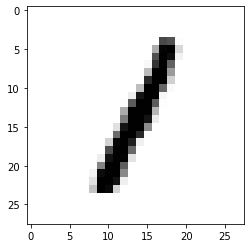

In [242]:
with torch.no_grad():
    # 테스트 데이터를 사용하여 모델을 테스트한다.
    x_test = mnist_test.data.view(-1, 28*28).float().to(device)
    y_test = mnist_test.targets.to(device)
    pred = model(x_test)
    correct_pred = torch.argmax(pred, 1) == y_test
    accuracy = correct_pred.float().mean()
    print("|pred|:", pred.shape)
    print(torch.argmax(pred, 1)) # 열을따라서, max인 idx저장
    print('Accuracy: ', accuracy.item())
    print('----------------------------------\n')
    
    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test)-1)
    x_test_one = mnist_test.data[r].view(-1, 28*28).float().to(device)
    y_test_one = mnist_test.targets[r].to(device)
    pred_one = model(x_test_one)
    print('Label:', y_test_one.item())
    print('pred:', torch.argmax(pred_one, 1).item())
    
    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()